# angcorrwat tutorial

This is a simple introduction to the angcorrwat library.
Examples for plotting and exporting C code are included.

## Setup plotting and printing

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (6., 4.)}
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, proj3d
from matplotlib.patches import FancyArrowPatch
from sympy import init_printing

init_printing()

## Imports

In [2]:
from sympy import Symbol, lambdify
import numpy as np
from angcorrwat import W

theta = Symbol('theta')
phi = Symbol('phi')
delta = Symbol('delta')

## Prepare plotting

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plot_angdist(angdist):
    fun = lambdify([theta, phi], angdist)
    p_theta, p_phi = np.linspace(0, np.pi, 60), np.linspace(0, 2 * np.pi, 60)
    THETA, PHI = np.meshgrid(p_theta, p_phi)
    R = fun(THETA, PHI)
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.cos(THETA)
    Z = R * np.sin(THETA) * np.sin(PHI)

    fmax, fmin = R.max(), R.min()

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_surface(
        X, Y, Z, facecolors=cm.jet(np.log(R+1)), rstride=1, cstride=1,
        linewidth=0, antialiased=True, alpha=1, shade=False)
    
    a1 = Arrow3D([-fmax, fmax], [0, 0], [0, 0],
                 mutation_scale=20, lw=2, arrowstyle="-|>", color="green")
    ax.add_artist(a1)
    a2 = Arrow3D([0, 0], [-fmax/3, fmax/3], [0, 0],
                 mutation_scale=20, lw=2, arrowstyle="<|-|>", color="k")
    ax.add_artist(a2)

    ax.set_xlim(-fmax, fmax)
    ax.set_ylim(-fmax, fmax)
    ax.set_zlim(-fmax, fmax)
    ax.view_init(azim=-135, elev=25)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

## Calculate angular distributions

Using angcorrwat, it is possible to easily calculate angular distributions:

A $1^+$ state is excited from a $0^+$ ground state in an NRF experiment using a linearily polarized $\gamma$-ray beam.
The subsequent decay to another lower-lying $0^+$ state is emitting radiation according to the following angular distribution:

In [4]:
res = W(theta, phi, [0, 1], [1, 1, 0], [[0, 0]])
res

Visualizing this function results in the following plot:

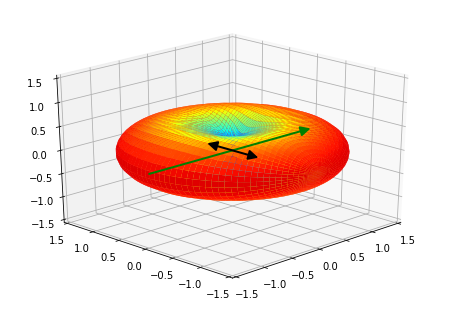

In [5]:
plot_angdist(res)

The direction of the incident $\gamma$-ray beam is indicated by the green arrow, the plane of polarization by the black arrow.

## Obtaining C code from result

Using sympy, it is very easy to export the resulting angular distribution to C:

In [6]:
from sympy.printing import ccode
print(ccode(res))

-1.5*pow(sin(phi), 2)*pow(sin(theta), 2) + 1.5


## Calculating arbitrary angular distributions

The function `W` takes several arguments:
The first two are the $\theta$- and $\phi$-angles.
Because we are not only interested in values for specific angles, we use sympys symbolic capabilities and pass the symbols `theta` and `phi` to the function.
The next argument defines the ground state.
For an even-even nucleus with a $0^+$ ground state, this corresponds to `[0, 1]`, with 0 referring to $J=0$ and 1 referring to positive parity (negative parity is 0).
The fourth argument defines the excited state.
For example, `[3, 0, 0]` refers to a $J^\pi=3^-$ state and a mixing of radiation charaters of 0.
Finally, the last argument is a list of states that are part of the subsequent decay cascade.
The angular distribution of the radiation emitted by the final state is returned by `W`.
Each state is defined by its parity $J$ and the multipole mixing ratio $\delta$.

## Complex example

Let’s take a look at a more complex angular distribution: $0^+ \rightarrow 2^+ \rightarrow 3 \rightarrow 1$

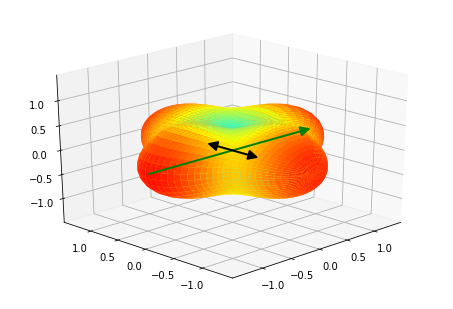

In [7]:
res = W(theta, phi, [0, 1], [2, 1, 0], [[3, 0], [1, 0]])
plot_angdist(res)
res